In [1]:
# importing needed modules
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.special import huber
import tensorflow as tf
import seaborn as sns
pd.options.mode.chained_assignment = None

2023-01-26 03:40:39.019116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 03:40:40.117054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-26 03:40:40.117156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-26 03:40:40.117167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# reading the dataset
df = pd.read_csv("traffic.csv",parse_dates=True, index_col='DateTime')
colors = [ "#5AECDE","#D985BB","#9BC7FF","#40863C"]

In [3]:
# splitting junctions
df1 = df[df["Junction"] == 1]
df2 = df[df["Junction"] == 2]
df3 = df[df["Junction"] == 3]
df4 = df[df["Junction"] == 4]


df1 = df1[['Vehicles']]
df2 = df2[['Vehicles']]
df3 = df3[['Vehicles']]
df4 = df4[['Vehicles']]


In [4]:
# df['Year'] = pd.Series(df.index).apply(lambda x: x.year).to_list()
# df['Month'] = pd.Series(df.index).apply(lambda x: x.month).to_list()
# df['Day'] = pd.Series(df.index).apply(lambda x: x.day).to_list()
# df['Hour'] = pd.Series(df.index).apply(lambda x: x.hour).to_list()


In [5]:
# plt.figure(figsize=(25,6))
# Time_series=sns.lineplot(x=df.index,y="Vehicles",data=df, hue="Junction",palette=colors)
# Time_series.set_title("Traffic On Junctions Over Years")
# Time_series.set_ylabel("Number of Vehicles")
# Time_series.set_xlabel("Date")

In [6]:
# plt.figure(figsize=(25,6))
# Time_series=sns.lineplot(x=df[(df.index >= '2017-01-01 00:00:00') & (df.index < '2017-02-01 00:00:00')].index,y="Vehicles",data=df[(df.index >= '2017-01-01 00:00:00') & (df.index < '2017-02-01 00:00:00')], hue="Junction",palette=colors)
# Time_series.set_title("Traffic On Junctions Over Years")
# Time_series.set_ylabel("Number of Vehicles")
# Time_series.set_xlabel("Date")

In [7]:
# new_features = [ "Year","Month", "Day", "Hour"]

# for i in new_features:
#     plt.figure(figsize=(25,6))
#     ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction",palette=colors)

In [8]:
# splitting train and test
train_start_dt = '2015-11-01 00:00:00'
test_start_dt = '2017-06-01 00:00:00'

train1 = df1.copy()[(df1.index >= train_start_dt) & (df1.index < test_start_dt)][['Vehicles']]
test1 = df1.copy()[df1.index >= test_start_dt][['Vehicles']]

train2 = df2.copy()[(df2.index >= train_start_dt) & (df2.index < test_start_dt)][['Vehicles']]
test2 = df2.copy()[df2.index >= test_start_dt][['Vehicles']]

train3 = df3.copy()[(df3.index >= train_start_dt) & (df3.index < test_start_dt)][['Vehicles']]
test3 = df3.copy()[df3.index >= test_start_dt][['Vehicles']]

train4 = df4.copy()[(df4.index >= '2017-01-01 00:00:00') & (df4.index < '2017-06-15 00:00:00')][['Vehicles']]
test4 = df4.copy()[df4.index >= '2017-06-15 00:00:00'][['Vehicles']]


In [9]:
# scaling vehicle values
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
scaler4 = MinMaxScaler()


train1['Vehicles'] = scaler1.fit_transform(train1[['Vehicles']])
test1['Vehicles'] = scaler1.transform(test1[['Vehicles']])

train2['Vehicles'] = scaler2.fit_transform(train2[['Vehicles']])
test2['Vehicles'] = scaler2.transform(test2[['Vehicles']])

train3['Vehicles'] = scaler3.fit_transform(train3[['Vehicles']])
test3['Vehicles'] = scaler3.transform(test3[['Vehicles']])

train4['Vehicles'] = scaler4.fit_transform(train4[['Vehicles']])
test4['Vehicles'] = scaler4.transform(test4[['Vehicles']])

In [10]:
# converting dataframe to numpy array
train_data1 = train1.values
test_data1 = test1.values

train_data2 = train2.values
test_data2 = test2.values

train_data3 = train3.values
test_data3 = test3.values

train_data4 = train4.values
test_data4 = test4.values

In [11]:
# timesteps :)
timesteps = 148
train_data1_timesteps=np.array([[j for j in train_data1[i:i+timesteps]] for i in range(0,len(train_data1)-timesteps+1)])[:,:,0]
test_data1_timesteps=np.array([[j for j in test_data1[i:i+timesteps]] for i in range(0,len(test_data1)-timesteps+1)])[:,:,0]

train_data2_timesteps=np.array([[j for j in train_data2[i:i+timesteps]] for i in range(0,len(train_data2)-timesteps+1)])[:,:,0]
test_data2_timesteps=np.array([[j for j in test_data2[i:i+timesteps]] for i in range(0,len(test_data2)-timesteps+1)])[:,:,0]

train_data3_timesteps=np.array([[j for j in train_data3[i:i+timesteps]] for i in range(0,len(train_data3)-timesteps+1)])[:,:,0]
test_data3_timesteps=np.array([[j for j in test_data3[i:i+timesteps]] for i in range(0,len(test_data3)-timesteps+1)])[:,:,0]

train_data4_timesteps=np.array([[j for j in train_data4[i:i+timesteps]] for i in range(0,len(train_data4)-timesteps+1)])[:,:,0]
test_data4_timesteps=np.array([[j for j in test_data4[i:i+timesteps]] for i in range(0,len(test_data4)-timesteps+1)])[:,:,0]

In [12]:
# splitting X and Y for test and train
x_train1, y_train1 = train_data1_timesteps[:,:timesteps-1],train_data1_timesteps[:,[timesteps-1]]
x_test1, y_test1 = test_data1_timesteps[:,:timesteps-1],test_data1_timesteps[:,[timesteps-1]]

x_train2, y_train2 = train_data2_timesteps[:,:timesteps-1],train_data2_timesteps[:,[timesteps-1]]
x_test2, y_test2 = test_data2_timesteps[:,:timesteps-1],test_data2_timesteps[:,[timesteps-1]]

x_train3, y_train3 = train_data3_timesteps[:,:timesteps-1],train_data3_timesteps[:,[timesteps-1]]
x_test3, y_test3 = test_data3_timesteps[:,:timesteps-1],test_data3_timesteps[:,[timesteps-1]]

x_train4, y_train4 = train_data4_timesteps[:,:timesteps-1],train_data4_timesteps[:,[timesteps-1]]
x_test4, y_test4 = test_data4_timesteps[:,:timesteps-1],test_data4_timesteps[:,[timesteps-1]]

In [13]:
len(y_test4)

237

In [14]:
# # fitting svr models
svr1 = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
svr2 = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
svr3 = SVR(kernel='rbf',gamma=0.1, C=1, epsilon = 0.005)
svr4 = SVR(kernel='rbf',gamma=0.1, C=1, epsilon = 0.005)

svr1.fit(x_train1, y_train1[:,0])
svr2.fit(x_train2, y_train2[:,0])
svr3.fit(x_train3, y_train3[:,0])
svr4.fit(x_train4, y_train4[:,0])

SVR(C=1, epsilon=0.005, gamma=0.1)

In [15]:
# fitting rf models
rf1 = RandomForestRegressor()
rf2 = RandomForestRegressor()
rf3 = RandomForestRegressor()
rf4 = RandomForestRegressor()

rf1.fit(x_train1, y_train1[:,0])
rf2.fit(x_train2, y_train2[:,0])
rf3.fit(x_train3, y_train3[:,0])
rf4.fit(x_train4, y_train4[:,0])

RandomForestRegressor()

In [16]:
# R2 score
print(svr1.score(x_test1, y_test1[:,0]))
print(rf1.score(x_test1, y_test1[:,0]))
print(svr2.score(x_test2, y_test2[:,0]))
print(rf2.score(x_test2, y_test2[:,0]))
print(svr3.score(x_test3, y_test3[:,0]))
print(rf3.score(x_test3, y_test3[:,0]))
print(svr4.score(x_test4, y_test4[:,0]))
print(rf4.score(x_test4, y_test4[:,0]))

0.9186152381711201
0.9639648206158744
0.708956459585038
0.9087934365321634
0.574049897810561
0.5433243825568461
0.5035197977282584
0.5353187382113616


In [17]:
svrp1 = (svr1.predict(x_test1))
print("svr:")
print("MAE:",round(mean_absolute_error( y_test1[:,0],svrp1),4),end="  ")
print("MSE:",round(mean_squared_error( y_test1[:,0],svrp1),4),end="  ")
print("RMSE:",round(mean_squared_error( y_test1[:,0],svrp1,squared=False),4),end="  ")
print("MAPE:",round(mean_absolute_percentage_error( y_test1[:,0],svrp1),4),end="  ")
print("HuberLoss:",round(tf.keras.losses.Huber()(y_test1[:,0], svrp1).numpy(),4))
rfp1 = (rf1.predict(x_test1))
print("rf:")
print("MAE:",round(mean_absolute_error( y_test1[:,0],rfp1),4),end="  ")
print("MSE:",round(mean_squared_error( y_test1[:,0],rfp1),4),end="  ")
print("RMSE:",round(mean_squared_error( y_test1[:,0],rfp1,squared=False),4),end="  ")
print("MAPE:",round(mean_absolute_percentage_error( y_test1[:,0],rfp1),4),end="  ")
print("HuberLoss:",round(tf.keras.losses.Huber()(y_test1[:,0], rfp1).numpy(),4))

svrp2 = (svr2.predict(x_test2))
print("svr:")
print("MAE:",round(mean_absolute_error( y_test2[:,0],svrp2),4),end="  ")
print("MSE:",round(mean_squared_error( y_test2[:,0],svrp2),4),end="  ")
print("RMSE:",round(mean_squared_error( y_test2[:,0],svrp2,squared=False),4),end="  ")
print("MAPE:",round(mean_absolute_percentage_error( y_test2[:,0],svrp2),4),end="  ")
print("HuberLoss:",round(tf.keras.losses.Huber()(y_test2[:,0], svrp2).numpy(),4))
rfp2 = (rf2.predict(x_test2))
print("rf:")
print("MAE:",round(mean_absolute_error( y_test2[:,0],rfp2),4),end="  ")
print("MSE:",round(mean_squared_error( y_test2[:,0],rfp2),4),end="  ")
print("RMSE:",round(mean_squared_error( y_test2[:,0],rfp2,squared=False),4),end="  ")
print("MAPE:",round(mean_absolute_percentage_error( y_test2[:,0],rfp2),4),end="  ")
print("HuberLoss:",round(tf.keras.losses.Huber()(y_test2[:,0], rfp2).numpy(),4))

svrp3 = (svr3.predict(x_test3))
print("svr:")
print("MAE:",round(mean_absolute_error( y_test3[:,0],svrp3),4),end="  ")
print("MSE:",round(mean_squared_error( y_test3[:,0],svrp3),4),end="  ")
print("RMSE:",round(mean_squared_error( y_test3[:,0],svrp3,squared=False),4),end="  ")
print("MAPE:",round(mean_absolute_percentage_error( y_test3[:,0],svrp3),4),end="  ")
print("HuberLoss:",round(tf.keras.losses.Huber()(y_test3[:,0], svrp3).numpy(),4))
rfp3 = (rf3.predict(x_test3))
print("rf:")
print("MAE:",round(mean_absolute_error( y_test3[:,0],rfp3),4),end="  ")
print("MSE:",round(mean_squared_error( y_test3[:,0],rfp3),4),end="  ")
print("RMSE:",round(mean_squared_error( y_test3[:,0],rfp3,squared=False),4),end="  ")
print("MAPE:",round(mean_absolute_percentage_error( y_test3[:,0],rfp3),4),end="  ")
print("HuberLoss:",round(tf.keras.losses.Huber()(y_test3[:,0], rfp3).numpy(),4))

svrp4 = (svr4.predict(x_test4))
print("svr:")
print("MAE:",round(mean_absolute_error( y_test4[:,0],svrp4),4),end="  ")
print("MSE:",round(mean_squared_error( y_test4[:,0],svrp4),4),end="  ")
print("RMSE:",round(mean_squared_error( y_test4[:,0],svrp4,squared=False),4),end="  ")
print("MAPE:",round(mean_absolute_percentage_error( y_test3[:,0],svrp3),4),end="  ")
print("HuberLoss:",round(tf.keras.losses.Huber()(y_test4[:,0], svrp4).numpy(),4))
rfp4 = (rf4.predict(x_test4))
print("rf:")
print("MAE:",round(mean_absolute_error( y_test4[:,0],rfp4),4),end="  ")
print("MSE:",round(mean_squared_error( y_test4[:,0],rfp4),4),end="  ")
print("RMSE:",round(mean_squared_error( y_test4[:,0],rfp4,squared=False),4),end="  ")
print("MAPE:",round(mean_absolute_percentage_error( y_test3[:,0],rfp3),4),end="  ")
print("HuberLoss:",round(tf.keras.losses.Huber()(y_test4[:,0], rfp4).numpy(),4))

svr:
MAE: 0.042  MSE: 0.0026  RMSE: 0.0514  MAPE: 0.1078  HuberLoss: 0.0013
rf:
MAE: 0.0256  MSE: 0.0012  RMSE: 0.0342  MAPE: 0.0579  HuberLoss: 0.0006


2023-01-26 03:45:18.991629: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-01-26 03:45:18.991831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: vahid
2023-01-26 03:45:18.991854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: vahid
2023-01-26 03:45:18.992255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.5
2023-01-26 03:45:18.992408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.78.1
2023-01-26 03:45:18.992460: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 525.78.1 does not match DSO version 525.85.5 -- cannot find working devices in this configuration
2023-01-26 03:45:18.9932

svr:
MAE: 0.0903  MSE: 0.0136  RMSE: 0.1168  MAPE: 0.1561  HuberLoss: 0.0068
rf:
MAE: 0.0515  MSE: 0.0043  RMSE: 0.0654  MAPE: 0.1063  HuberLoss: 0.0021
svr:
MAE: 0.0174  MSE: 0.002  RMSE: 0.0443  MAPE: 0.1823  HuberLoss: 0.001
rf:
MAE: 0.0188  MSE: 0.0021  RMSE: 0.0459  MAPE: 0.1926  HuberLoss: 0.0011
svr:
MAE: 0.0733  MSE: 0.0118  RMSE: 0.1087  MAPE: 0.1823  HuberLoss: 0.0059
rf:
MAE: 0.068  MSE: 0.0111  RMSE: 0.1052  MAPE: 0.1926  HuberLoss: 0.0055


In [18]:
# predicting next year (2017 - 2018)
df_nextyear_svr_j1 = df1.copy()[(df1.index >= '2017-01-01 00:00:00') & (df1.index < '2017-01-08 00:00:00')][['Vehicles']]
df_nextyear_svr_j2 = df2.copy()[(df2.index >= '2017-01-01 00:00:00') & (df2.index < '2017-01-08 00:00:00')][['Vehicles']]
df_nextyear_svr_j3 = df3.copy()[(df3.index >= '2017-01-01 00:00:00') & (df3.index < '2017-01-08 00:00:00')][['Vehicles']]
df_nextyear_svr_j4 = df4.copy()[(df4.index >= '2017-01-01 00:00:00') & (df4.index < '2017-01-08 00:00:00')][['Vehicles']]

df_nextyear_rf_j1 = df1.copy()[(df1.index >= '2017-01-01 00:00:00') & (df1.index < '2017-01-08 00:00:00')][['Vehicles']]
df_nextyear_rf_j2 = df2.copy()[(df2.index >= '2017-01-01 00:00:00') & (df2.index < '2017-01-08 00:00:00')][['Vehicles']]
df_nextyear_rf_j3 = df3.copy()[(df3.index >= '2017-01-01 00:00:00') & (df3.index < '2017-01-08 00:00:00')][['Vehicles']]
df_nextyear_rf_j4 = df4.copy()[(df4.index >= '2017-01-01 00:00:00') & (df4.index < '2017-01-08 00:00:00')][['Vehicles']]

temp_time = datetime.strptime('2017-01-08 00:00:00', '%Y-%m-%d %H:%M:%S')


df_nextyear_svr_j1['Vehicles'] = scaler1.transform(df_nextyear_svr_j1[['Vehicles']])
df_nextyear_svr_j2['Vehicles'] = scaler2.transform(df_nextyear_svr_j2[['Vehicles']])
df_nextyear_svr_j3['Vehicles'] = scaler3.transform(df_nextyear_svr_j3[['Vehicles']])
df_nextyear_svr_j4['Vehicles'] = scaler4.transform(df_nextyear_svr_j4[['Vehicles']])

df_nextyear_rf_j1['Vehicles'] = scaler1.transform(df_nextyear_rf_j1[['Vehicles']])
df_nextyear_rf_j2['Vehicles'] = scaler2.transform(df_nextyear_rf_j2[['Vehicles']])
df_nextyear_rf_j3['Vehicles'] = scaler3.transform(df_nextyear_rf_j3[['Vehicles']])
df_nextyear_rf_j4['Vehicles'] = scaler4.transform(df_nextyear_rf_j4[['Vehicles']])


nextyear_svr_j1 = df_nextyear_svr_j1.values[-147:][:,0]
nextyear_svr_j2 = df_nextyear_svr_j2.values[-147:][:,0]
nextyear_svr_j3 = df_nextyear_svr_j3.values[-147:][:,0]
nextyear_svr_j4 = df_nextyear_svr_j4.values[-147:][:,0]

nextyear_rf_j1 = df_nextyear_rf_j1.values[-147:][:,0]
nextyear_rf_j2 = df_nextyear_rf_j2.values[-147:][:,0]
nextyear_rf_j3 = df_nextyear_rf_j3.values[-147:][:,0]
nextyear_rf_j4 = df_nextyear_rf_j4.values[-147:][:,0]


while temp_time < datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S'):
    temp_time += timedelta(hours=1) 
    temp_p1 = svr1.predict([nextyear_svr_j1[-147:]])
    temp_p2 = svr2.predict([nextyear_svr_j2[-147:]])
    temp_p3 = svr3.predict([nextyear_svr_j3[-147:]])
    temp_p4 = svr4.predict([nextyear_svr_j4[-147:]])
    temp_p5 = rf1.predict([nextyear_rf_j1[-147:]])
    temp_p6 = rf2.predict([nextyear_rf_j2[-147:]])
    temp_p7 = rf3.predict([nextyear_rf_j3[-147:]])
    temp_p8 = rf4.predict([nextyear_rf_j4[-147:]])

    nextyear_svr_j1 = np.append(nextyear_svr_j1,temp_p1)
    df_nextyear_svr_j1.loc[temp_time] = temp_p1
    nextyear_svr_j2 = np.append(nextyear_svr_j2,temp_p2)
    df_nextyear_svr_j2.loc[temp_time] = temp_p2
    nextyear_svr_j3 = np.append(nextyear_svr_j3,temp_p3)
    df_nextyear_svr_j3.loc[temp_time] = temp_p3
    nextyear_svr_j4 = np.append(nextyear_svr_j4,temp_p4)
    df_nextyear_svr_j4.loc[temp_time] = temp_p4

    nextyear_rf_j1 = np.append(nextyear_rf_j1,temp_p5)
    df_nextyear_rf_j1.loc[temp_time] = temp_p5
    nextyear_rf_j2 = np.append(nextyear_rf_j2,temp_p6)
    df_nextyear_rf_j2.loc[temp_time] = temp_p6
    nextyear_rf_j3 = np.append(nextyear_rf_j3,temp_p7)
    df_nextyear_rf_j3.loc[temp_time] = temp_p7
    nextyear_rf_j4 = np.append(nextyear_rf_j4,temp_p8)
    df_nextyear_rf_j4.loc[temp_time] = temp_p8



In [19]:
nextyear_timestamps = df_nextyear_svr_j1.index
nextyear_pred_svr_j1 = scaler1.inverse_transform(df_nextyear_svr_j1)
nextyear_pred_svr_j2 = scaler2.inverse_transform(df_nextyear_svr_j2)
nextyear_pred_svr_j3 = scaler3.inverse_transform(df_nextyear_svr_j3)
nextyear_pred_svr_j4 = scaler4.inverse_transform(df_nextyear_svr_j4)

nextyear_pred_rf_j1 = scaler1.inverse_transform(df_nextyear_rf_j1)
nextyear_pred_rf_j2 = scaler2.inverse_transform(df_nextyear_rf_j2)
nextyear_pred_rf_j3 = scaler3.inverse_transform(df_nextyear_rf_j3)
nextyear_pred_rf_j4 = scaler4.inverse_transform(df_nextyear_rf_j4)

timestamps_6mo = df1[(df1.index >= '2017-01-01 00:00:00') & (df1.index < '2017-06-30 00:00:00')].index
Actual1 = df1.copy()[(df1.index >= '2017-01-01 00:00:00') & (df1.index < '2017-06-30 00:00:00')][['Vehicles']]
Actual2 = df2.copy()[(df2.index >= '2017-01-01 00:00:00') & (df2.index < '2017-06-30 00:00:00')][['Vehicles']]
Actual3 = df3.copy()[(df3.index >= '2017-01-01 00:00:00') & (df3.index < '2017-06-30 00:00:00')][['Vehicles']]
Actual4 = df4.copy()[(df4.index >= '2017-01-01 00:00:00') & (df4.index < '2017-06-30 00:00:00')][['Vehicles']]


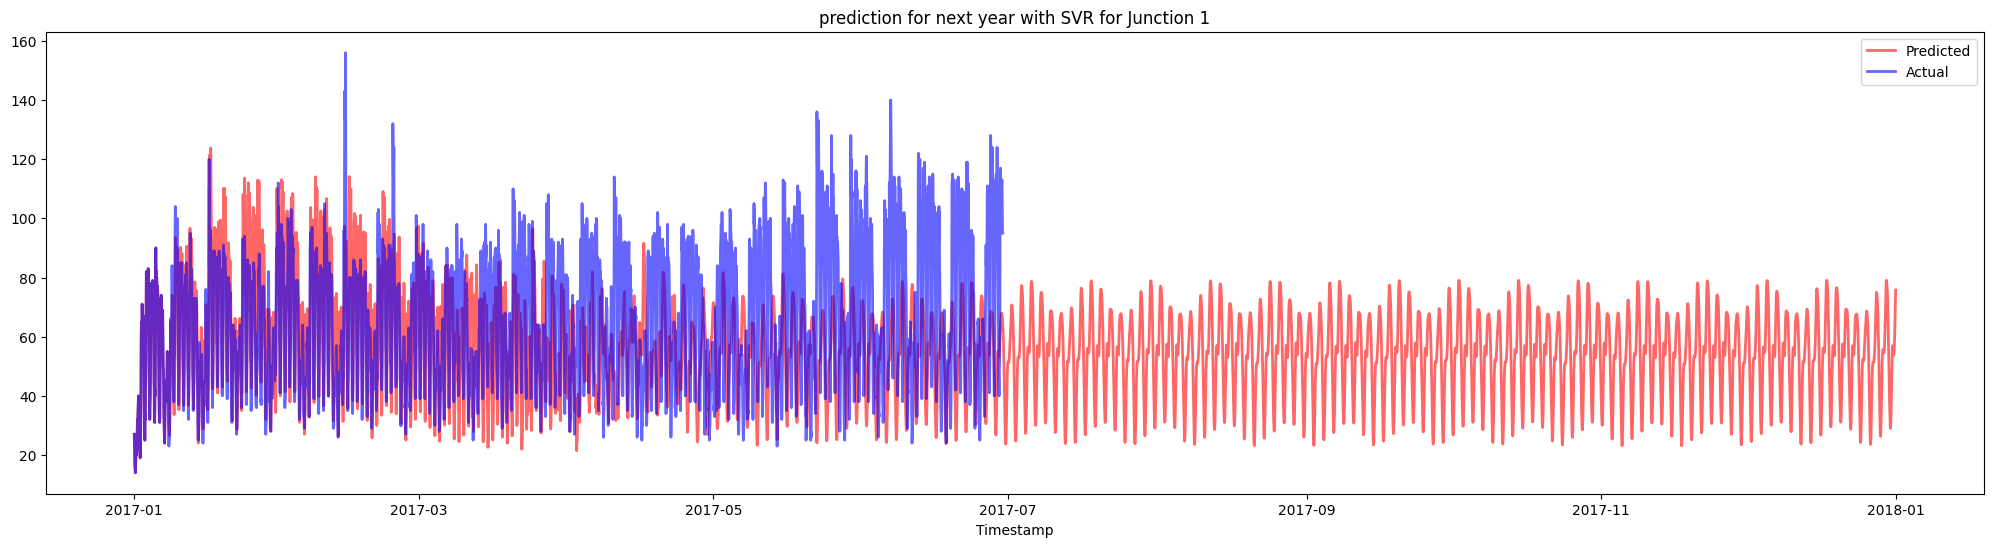

In [20]:
plt.figure(figsize=(25,6))

plt.plot(nextyear_timestamps, nextyear_pred_svr_j1, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(timestamps_6mo, Actual1, color = 'blue', linewidth=2.0, alpha = 0.6)

plt.legend(['Predicted','Actual'])
plt.xlabel('Timestamp')
plt.title("prediction for next year with SVR for Junction 1")
plt.show()

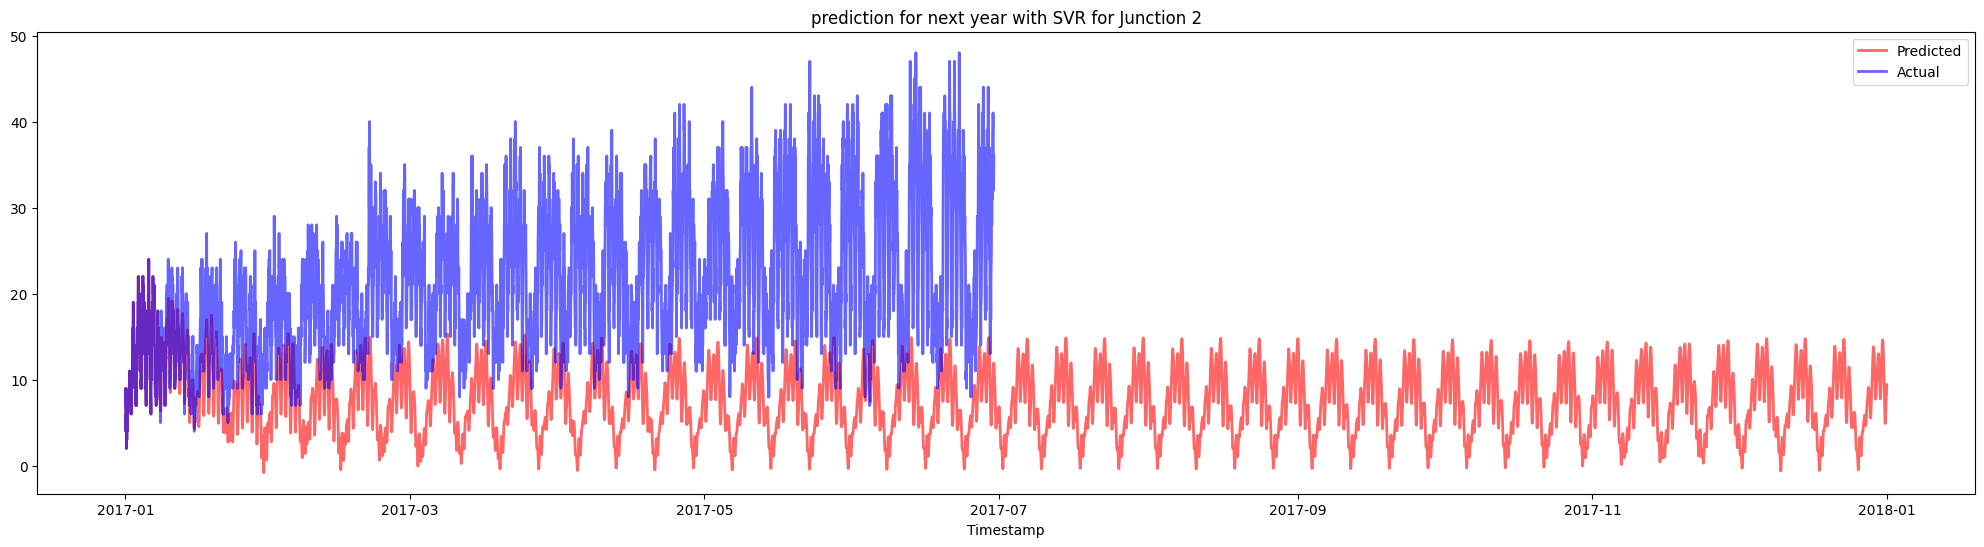

In [21]:
plt.figure(figsize=(25,6))

plt.plot(nextyear_timestamps, nextyear_pred_svr_j2, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(timestamps_6mo, Actual2, color = 'blue', linewidth=2.0, alpha = 0.6)

plt.legend(['Predicted','Actual'])
plt.xlabel('Timestamp')
plt.title("prediction for next year with SVR for Junction 2")
plt.show()

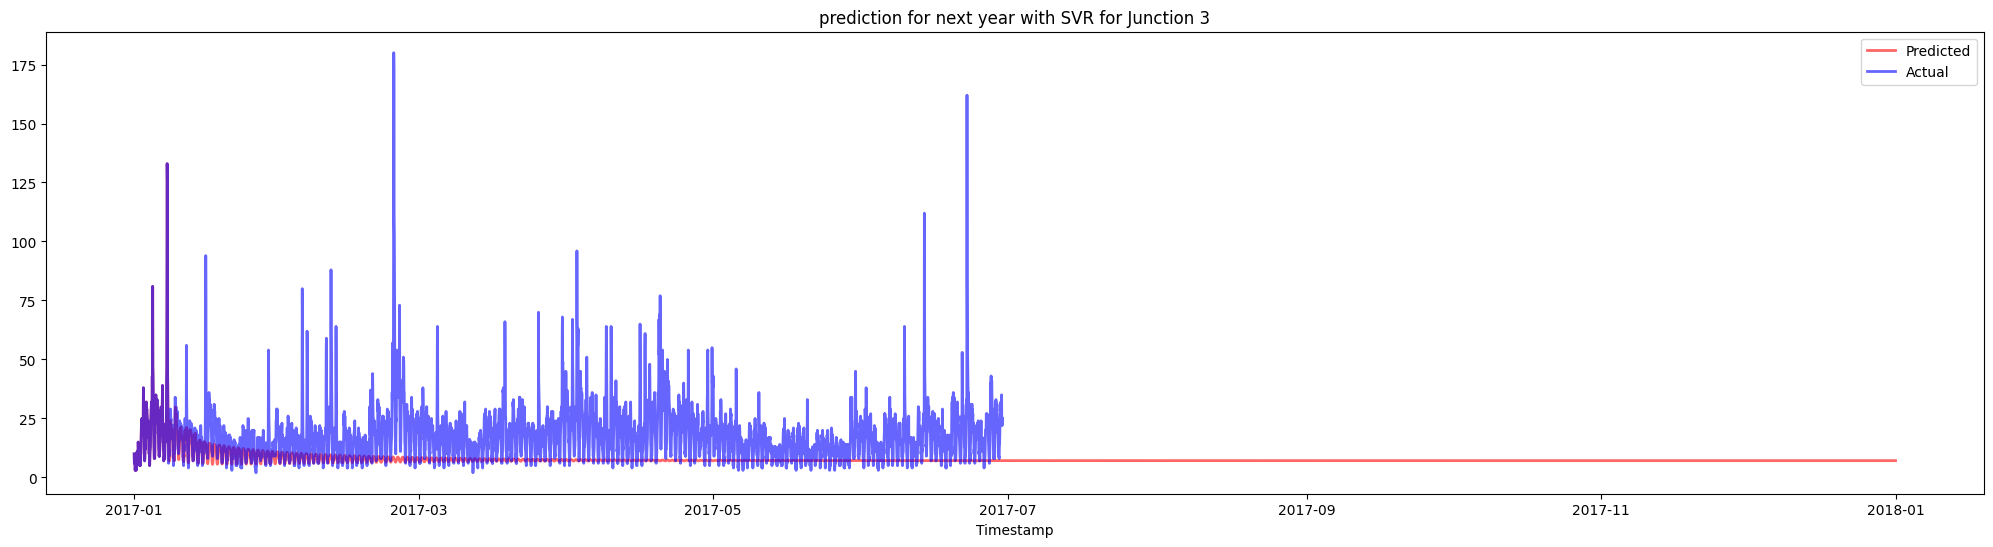

In [22]:
plt.figure(figsize=(25,6))

plt.plot(nextyear_timestamps, nextyear_pred_svr_j3, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(timestamps_6mo, Actual3, color = 'blue', linewidth=2.0, alpha = 0.6)

plt.legend(['Predicted','Actual'])
plt.xlabel('Timestamp')
plt.title("prediction for next year with SVR for Junction 3")
plt.show()

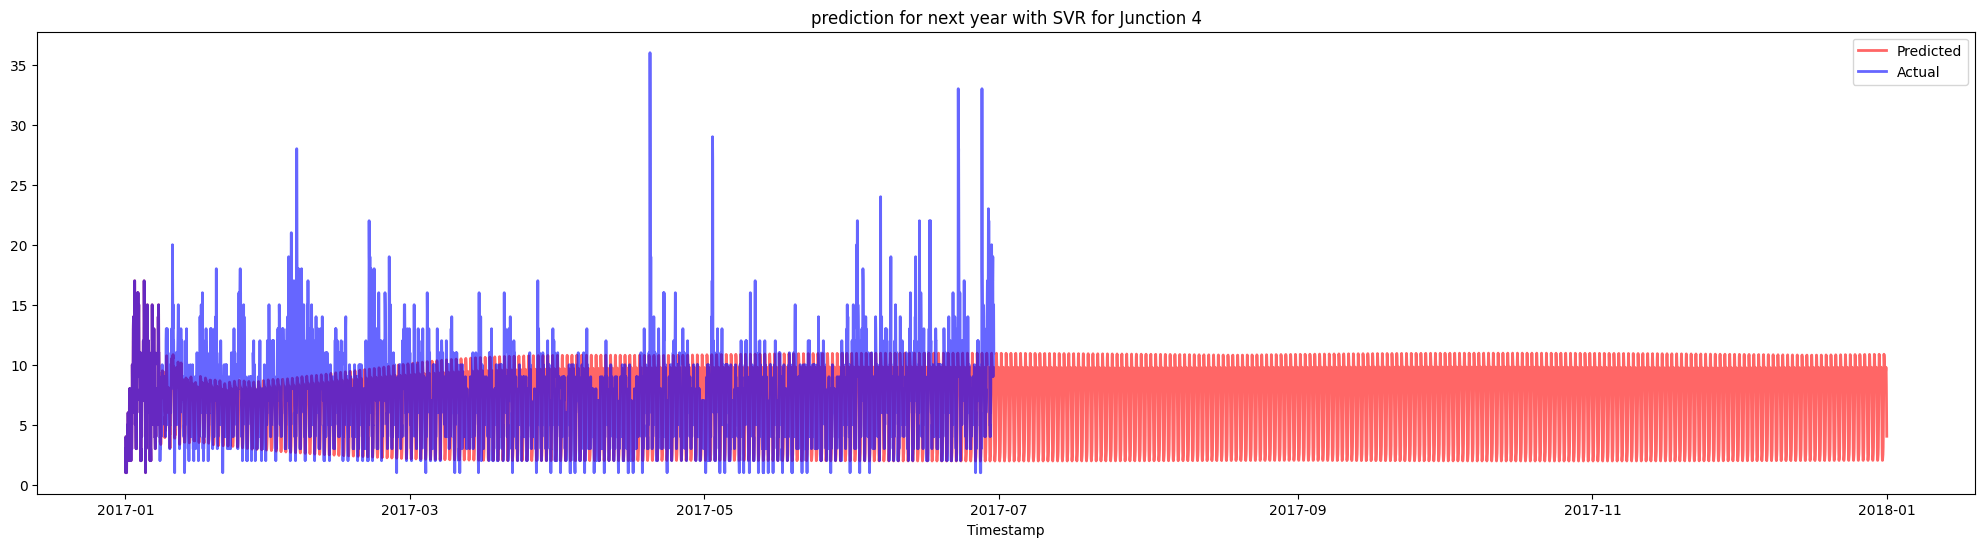

In [23]:
plt.figure(figsize=(25,6))

plt.plot(nextyear_timestamps, nextyear_pred_svr_j4, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(timestamps_6mo, Actual4, color = 'blue', linewidth=2.0, alpha = 0.6)

plt.legend(['Predicted','Actual'])
plt.xlabel('Timestamp')
plt.title("prediction for next year with SVR for Junction 4")
plt.show()

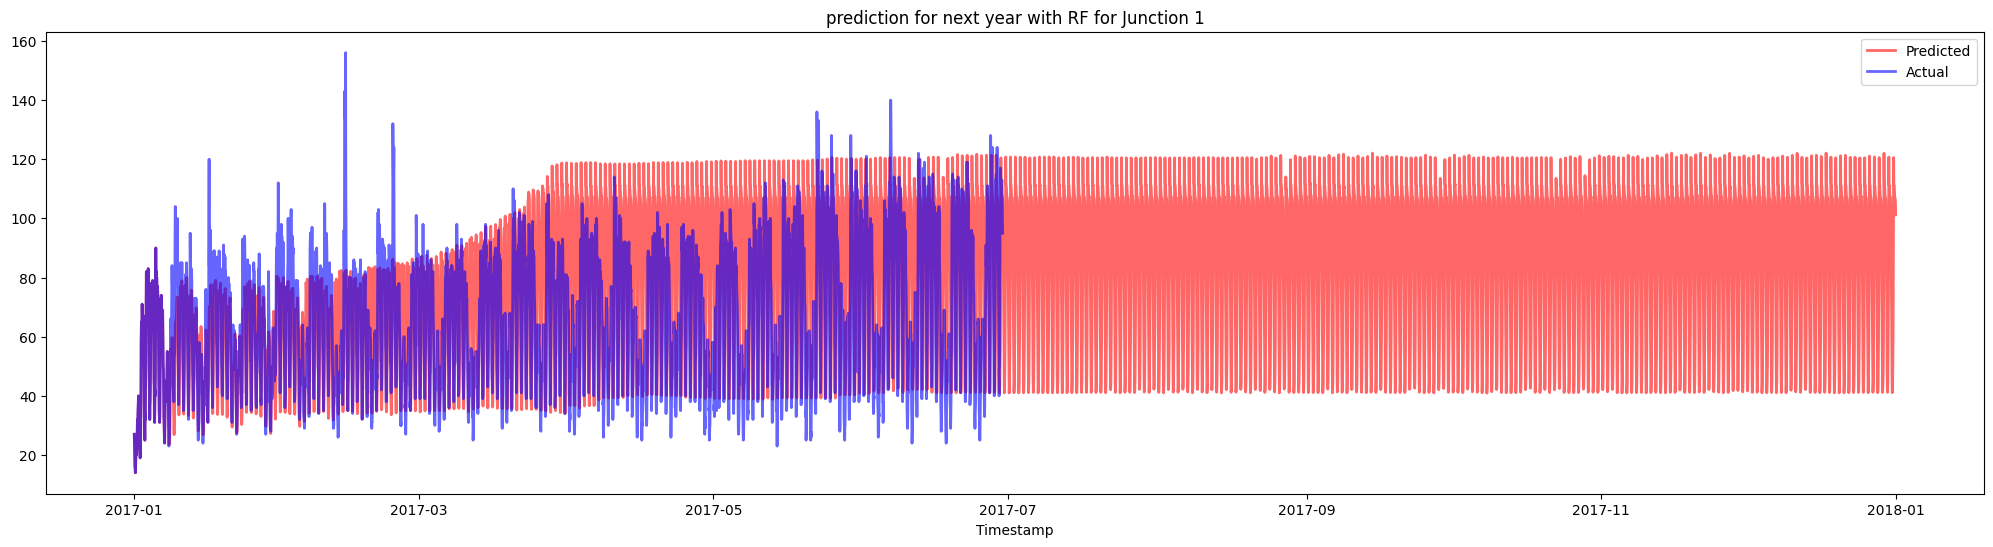

In [24]:
plt.figure(figsize=(25,6))

plt.plot(nextyear_timestamps, nextyear_pred_rf_j1, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(timestamps_6mo, Actual1, color = 'blue', linewidth=2.0, alpha = 0.6)

plt.legend(['Predicted','Actual'])
plt.xlabel('Timestamp')
plt.title("prediction for next year with RF for Junction 1")
plt.show()

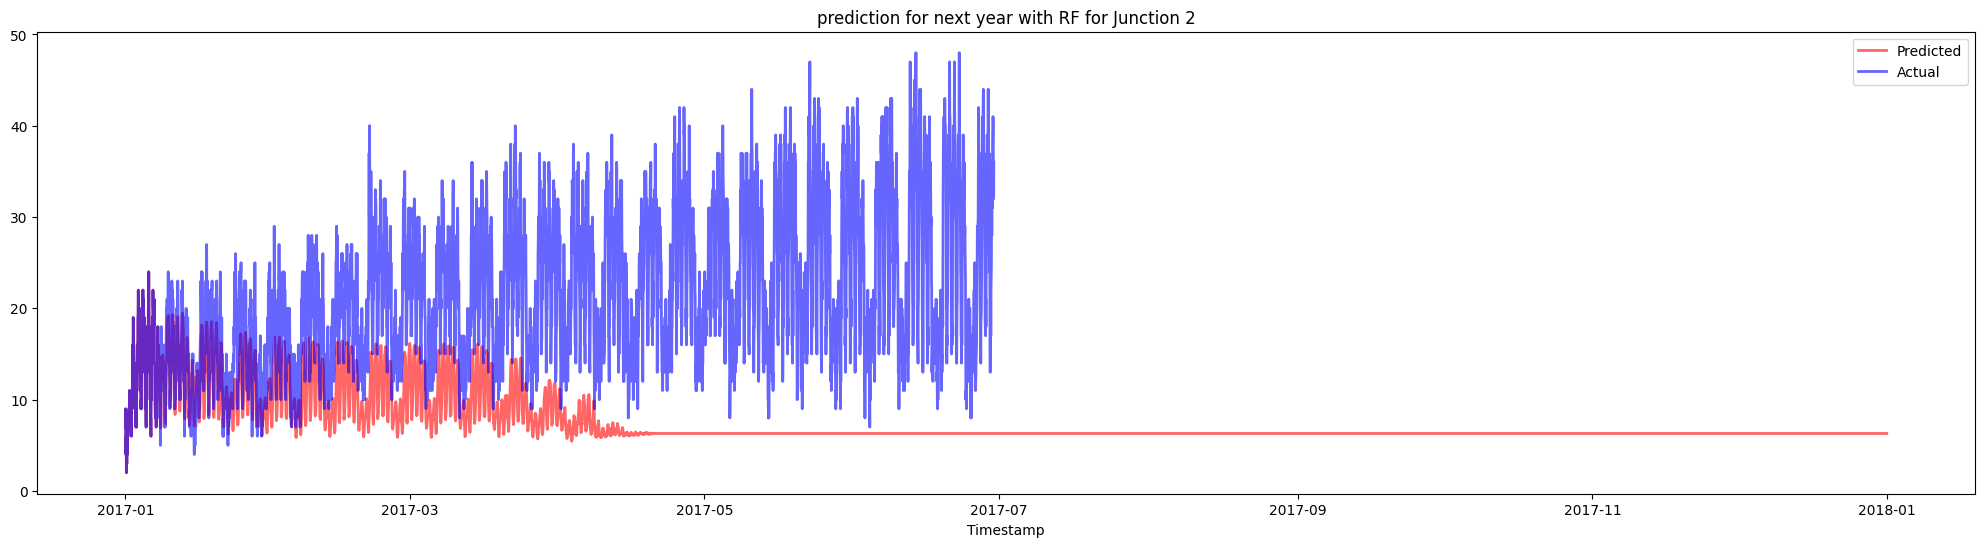

In [25]:
plt.figure(figsize=(25,6))

plt.plot(nextyear_timestamps, nextyear_pred_rf_j2, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(timestamps_6mo, Actual2, color = 'blue', linewidth=2.0, alpha = 0.6)

plt.legend(['Predicted','Actual'])
plt.xlabel('Timestamp')
plt.title("prediction for next year with RF for Junction 2")
plt.show()

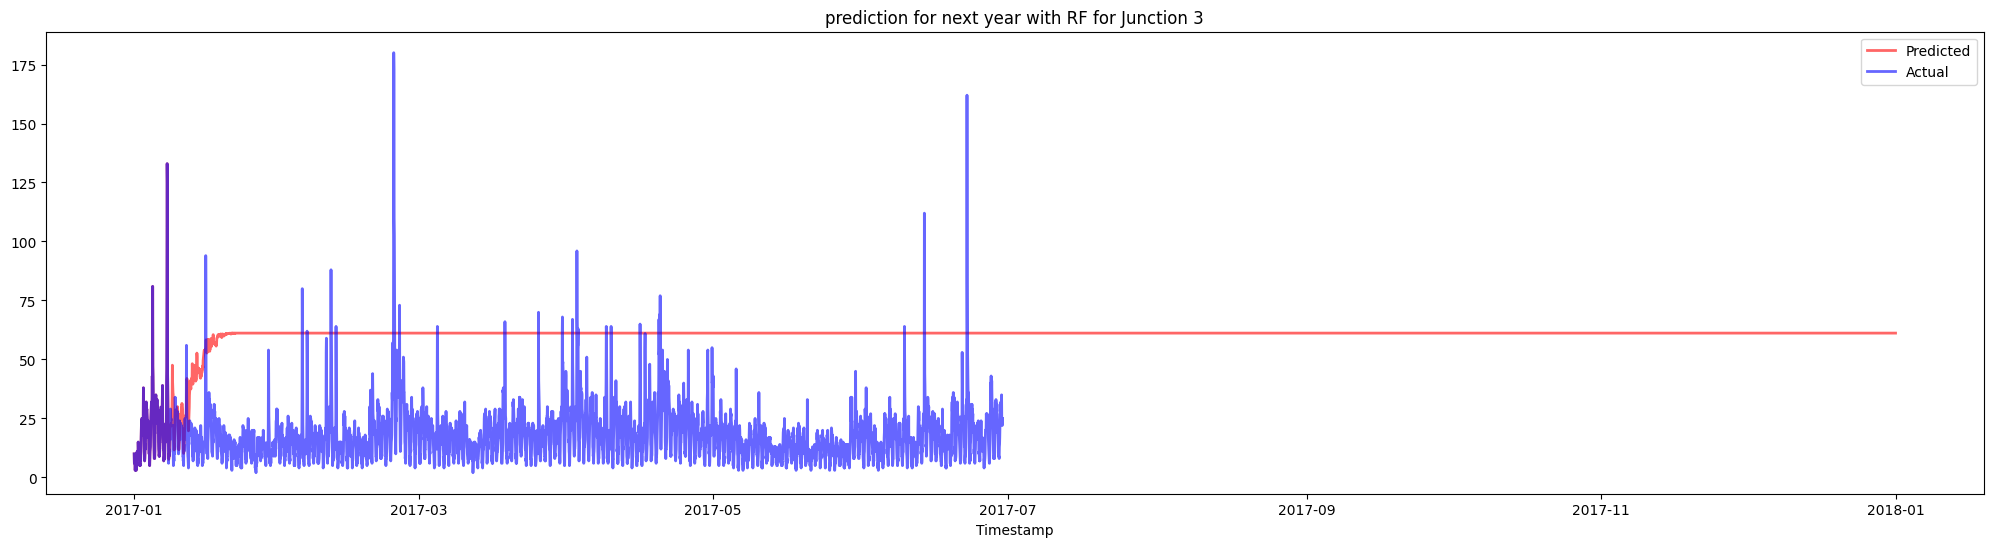

In [26]:
plt.figure(figsize=(25,6))

plt.plot(nextyear_timestamps, nextyear_pred_rf_j3, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(timestamps_6mo, Actual3, color = 'blue', linewidth=2.0, alpha = 0.6)

plt.legend(['Predicted','Actual'])
plt.xlabel('Timestamp')
plt.title("prediction for next year with RF for Junction 3")
plt.show()

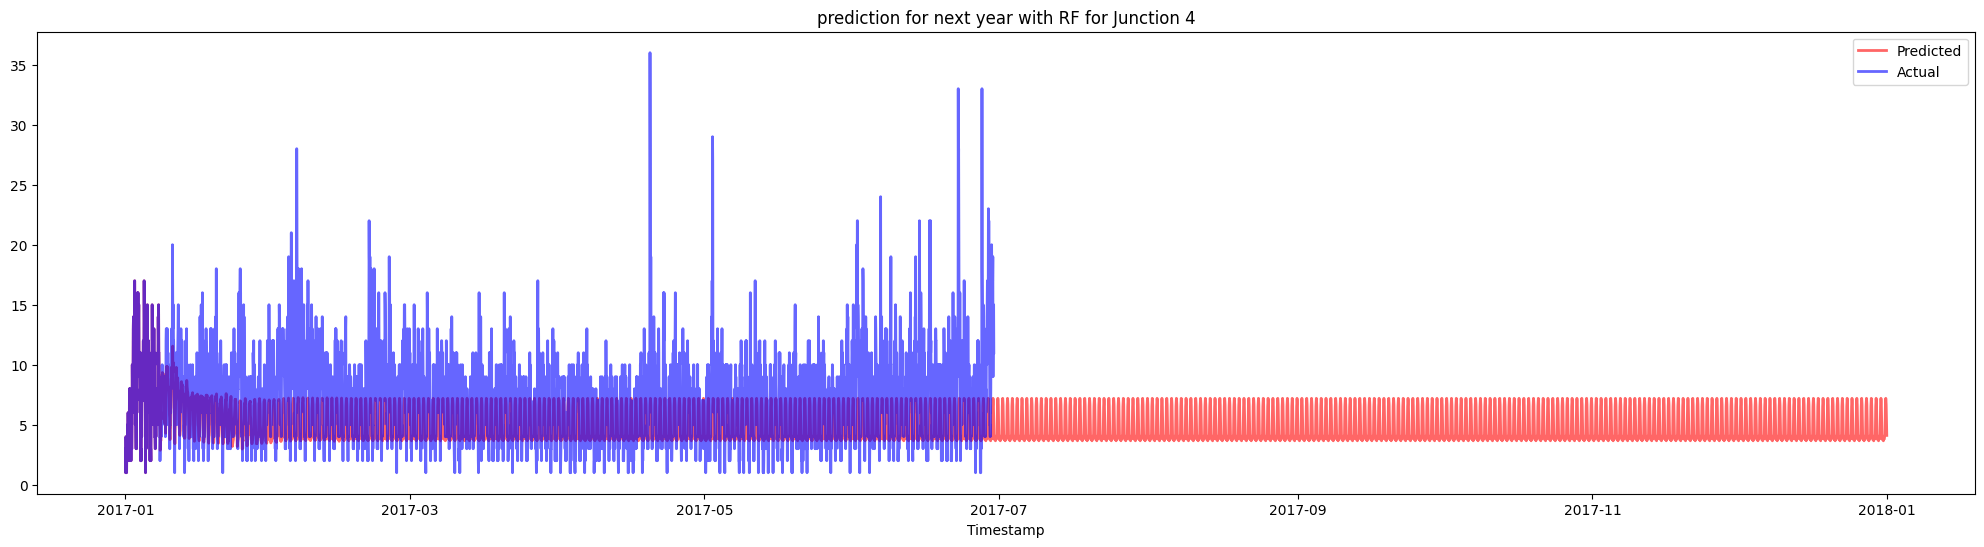

In [27]:
plt.figure(figsize=(25,6))

plt.plot(nextyear_timestamps, nextyear_pred_rf_j4, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(timestamps_6mo, Actual4, color = 'blue', linewidth=2.0, alpha = 0.6)

plt.legend(['Predicted','Actual'])
plt.xlabel('Timestamp')
plt.title("prediction for next year with RF for Junction 4")
plt.show()

In [28]:
# predicting train and test with svr
y_train_pred_svr_j1 = svr1.predict(x_train1).reshape(-1,1)
y_test_pred_svr_j1 = svr1.predict(x_test1).reshape(-1,1)

y_train_pred_svr_j2 = svr2.predict(x_train2).reshape(-1,1)
y_test_pred_svr_j2 = svr2.predict(x_test2).reshape(-1,1)

y_train_pred_svr_j3 = svr3.predict(x_train3).reshape(-1,1)
y_test_pred_svr_j3 = svr3.predict(x_test3).reshape(-1,1)

y_train_pred_svr_j4 = svr4.predict(x_train4).reshape(-1,1)
y_test_pred_svr_j4 = svr4.predict(x_test4).reshape(-1,1)

In [29]:
# predicting train and test with randomforest
y_train_pred_rf_j1 = rf1.predict(x_train1).reshape(-1,1)
y_test_pred_rf_j1 = rf1.predict(x_test1).reshape(-1,1)

y_train_pred_rf_j2 = rf2.predict(x_train2).reshape(-1,1)
y_test_pred_rf_j2 = rf2.predict(x_test2).reshape(-1,1)

y_train_pred_rf_j3 = rf3.predict(x_train3).reshape(-1,1)
y_test_pred_rf_j3 = rf3.predict(x_test3).reshape(-1,1)

y_train_pred_rf_j4 = rf4.predict(x_train4).reshape(-1,1)
y_test_pred_rf_j4 = rf4.predict(x_test4).reshape(-1,1)

In [30]:
# Scaling the svr predictions
y_train_pred_svr_j1 = scaler1.inverse_transform(y_train_pred_svr_j1)
y_test_pred_svr_j1 = scaler1.inverse_transform(y_test_pred_svr_j1)

y_train_pred_svr_j2 = scaler2.inverse_transform(y_train_pred_svr_j2)
y_test_pred_svr_j2 = scaler2.inverse_transform(y_test_pred_svr_j2)

y_train_pred_svr_j3 = scaler3.inverse_transform(y_train_pred_svr_j3)
y_test_pred_svr_j3 = scaler3.inverse_transform(y_test_pred_svr_j3)

y_train_pred_svr_j4 = scaler4.inverse_transform(y_train_pred_svr_j4)
y_test_pred_svr_j4 = scaler4.inverse_transform(y_test_pred_svr_j4)


In [31]:
# Scaling the randomforest predictions

y_train_pred_rf_j1 = scaler1.inverse_transform(y_train_pred_rf_j1)
y_test_pred_rf_j1 = scaler1.inverse_transform(y_test_pred_rf_j1)

y_train_pred_rf_j2 = scaler2.inverse_transform(y_train_pred_rf_j2)
y_test_pred_rf_j2 = scaler2.inverse_transform(y_test_pred_rf_j2)

y_train_pred_rf_j3 = scaler3.inverse_transform(y_train_pred_rf_j3)
y_test_pred_rf_j3 = scaler3.inverse_transform(y_test_pred_rf_j3)

y_train_pred_rf_j4 = scaler4.inverse_transform(y_train_pred_rf_j4)
y_test_pred_rf_j4 = scaler4.inverse_transform(y_test_pred_rf_j4)

In [32]:
# Scaling the actual values
y_train1 = scaler1.inverse_transform(y_train1)
y_test1 = scaler1.inverse_transform(y_test1)

y_train2 = scaler2.inverse_transform(y_train2)
y_test2 = scaler2.inverse_transform(y_test2)

y_train3 = scaler3.inverse_transform(y_train3)
y_test3 = scaler3.inverse_transform(y_test3)

y_train4 = scaler4.inverse_transform(y_train4)
y_test4 = scaler4.inverse_transform(y_test4)

In [33]:
train_timestamps = df1[(df1.index < test_start_dt) & (df1.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df1[test_start_dt:].index[timesteps-1:]

train_timestamps4 = df4[(df4.index < '2017-06-15 00:00:00') & (df4.index >= '2017-01-01 00:00:00')].index[timesteps-1:]
test_timestamps4 = df4['2017-06-15 00:00:00':].index[timesteps-1:]


In [34]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train1, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred_svr_j1, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction with SVR for Junction 1")
plt.show()

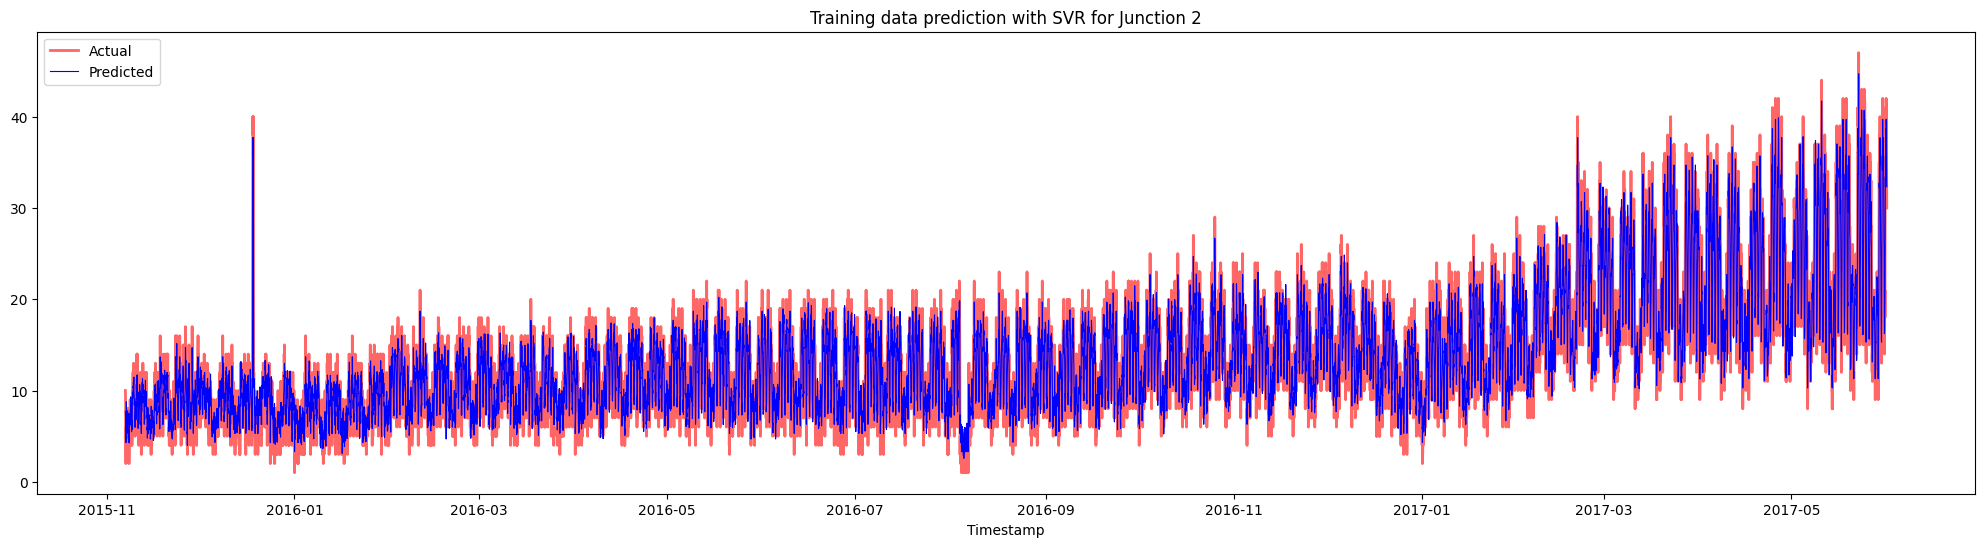

In [35]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train2, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred_svr_j2, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction with SVR for Junction 2")
plt.show()

In [36]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train3, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred_svr_j3, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction with SVR for Junction 3")
plt.show()

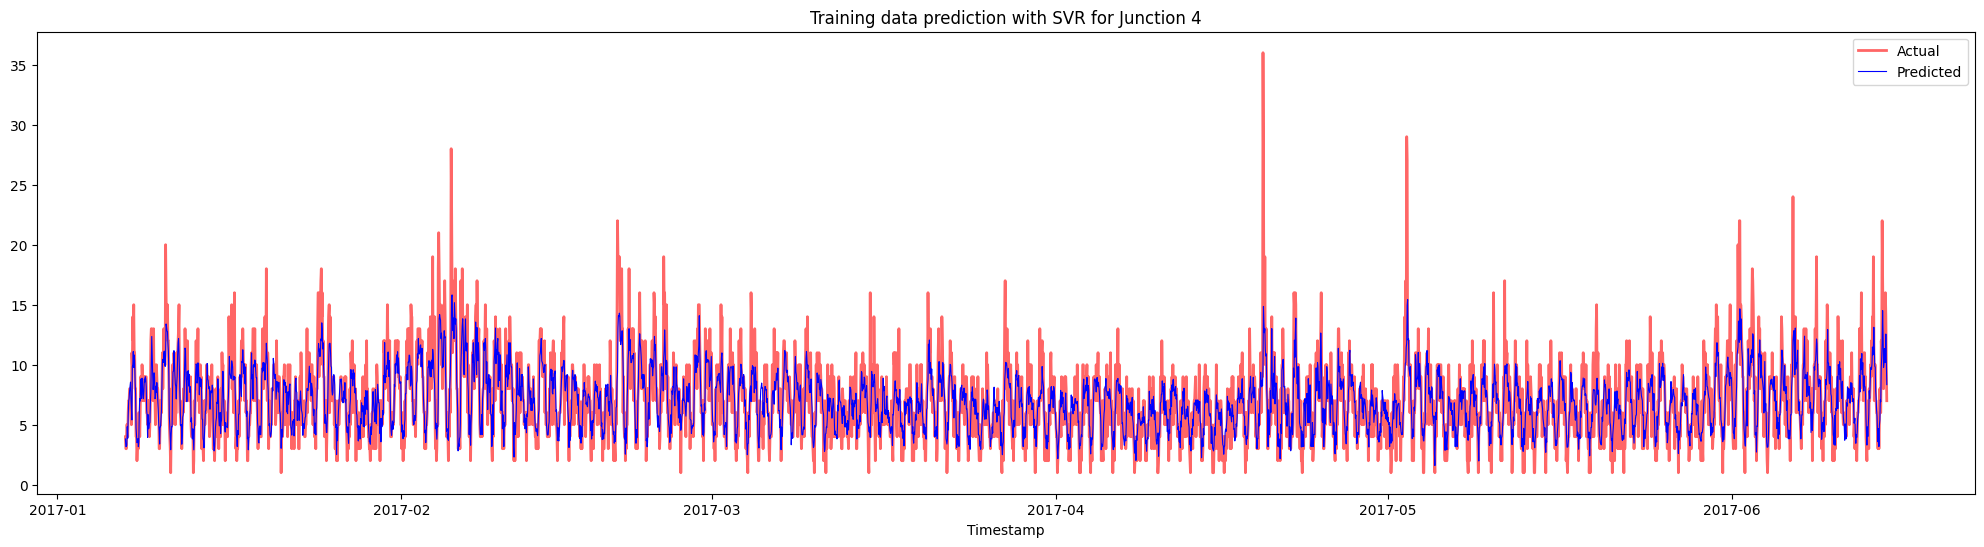

In [37]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps4, y_train4, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps4, y_train_pred_svr_j4, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction with SVR for Junction 4")
plt.show()

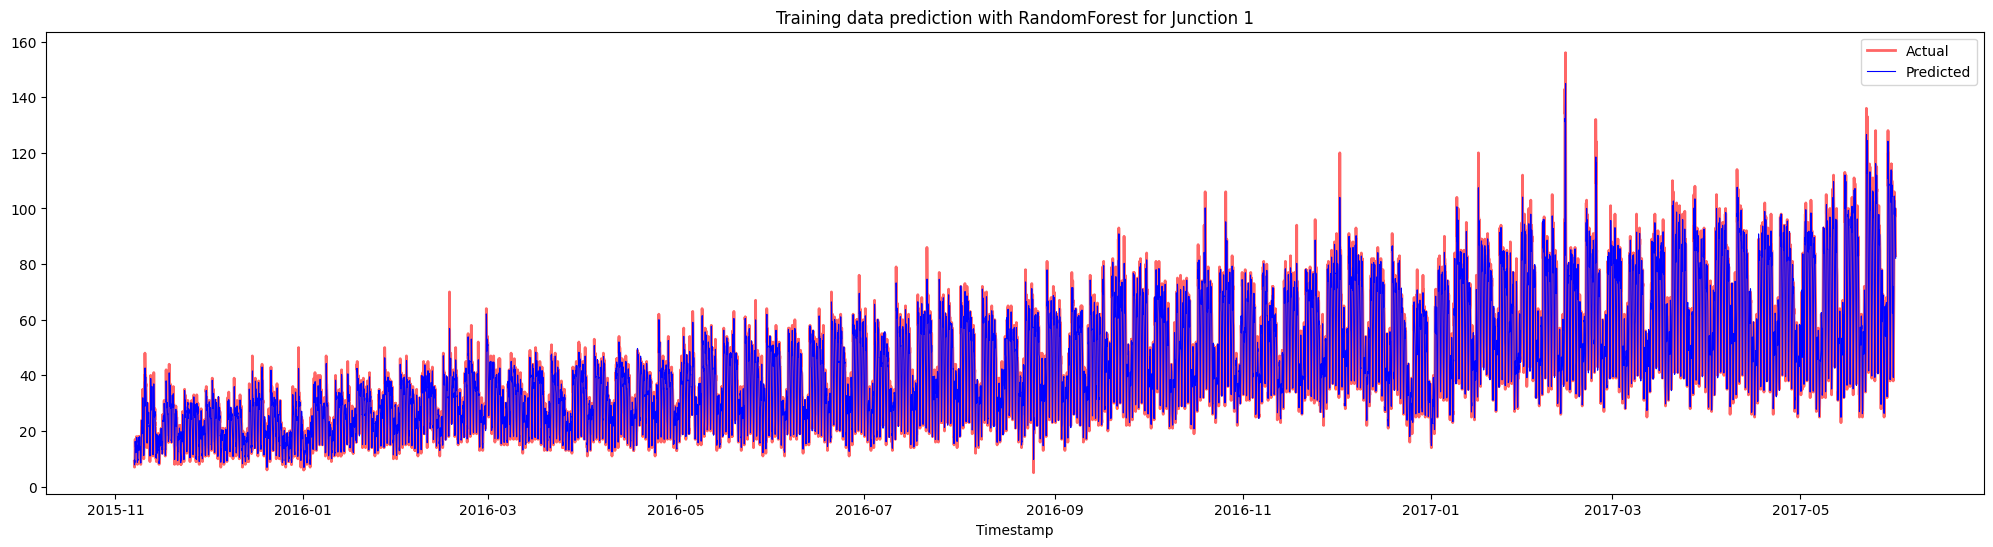

In [38]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train1, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred_rf_j1, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction with RandomForest for Junction 1")
plt.show()

In [39]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train2, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred_rf_j2, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction with RandomForest for Junction 2")
plt.show()

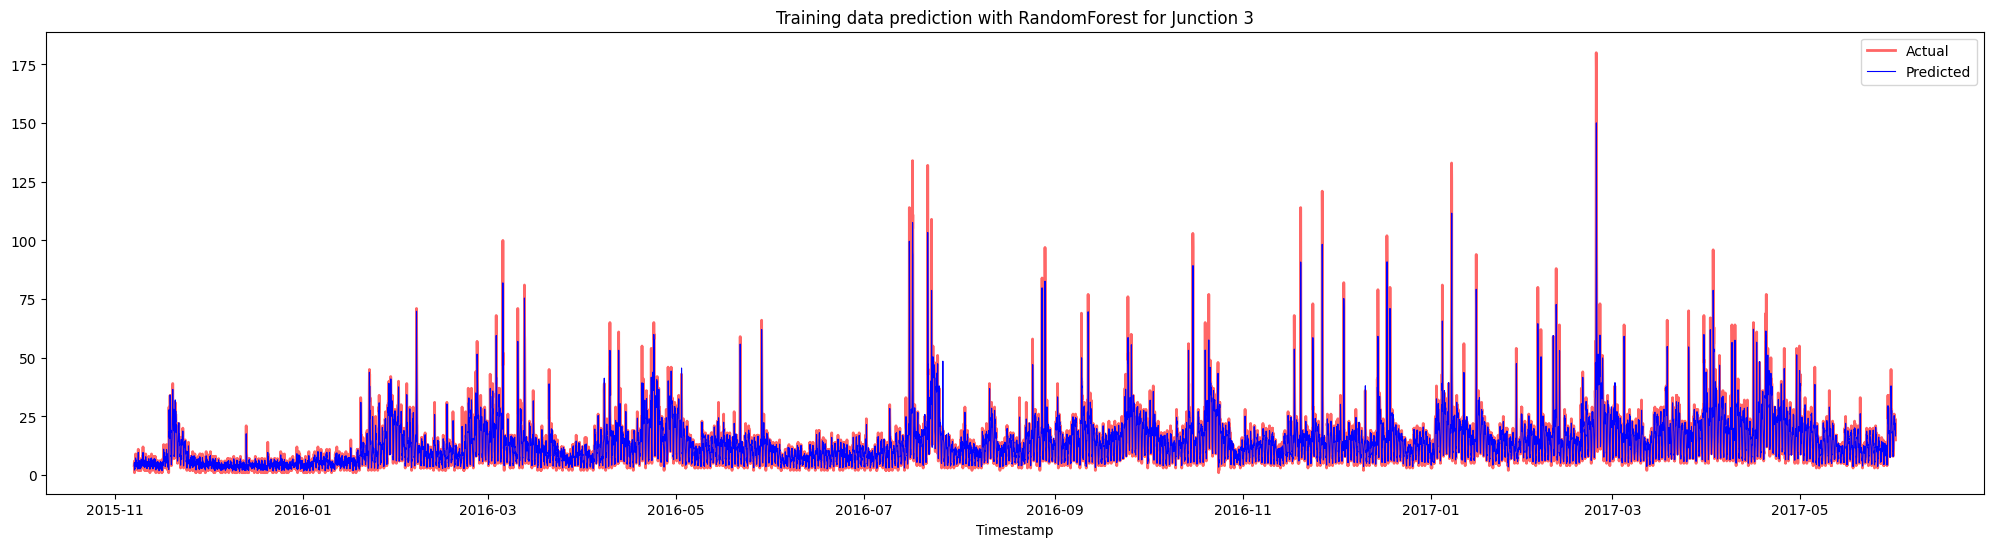

In [40]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train3, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred_rf_j3, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction with RandomForest for Junction 3")
plt.show()

In [41]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps4, y_train4, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps4, y_train_pred_rf_j4, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction with RandomForest for Junction 4")
plt.show()

In [42]:
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test1, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred_svr_j1, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Test data prediction with SVR for Junction 1")
plt.show()

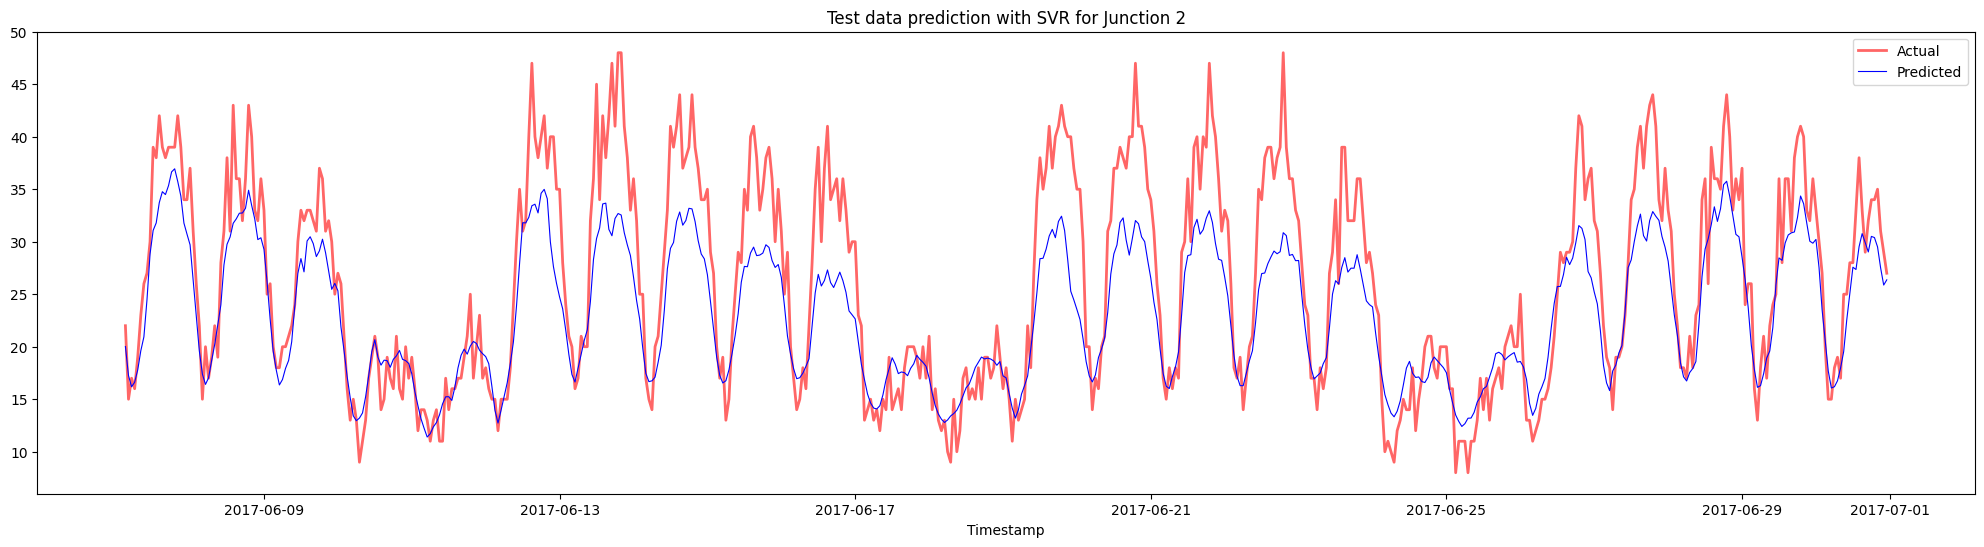

In [43]:
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test2, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred_svr_j2, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Test data prediction with SVR for Junction 2")
plt.show()

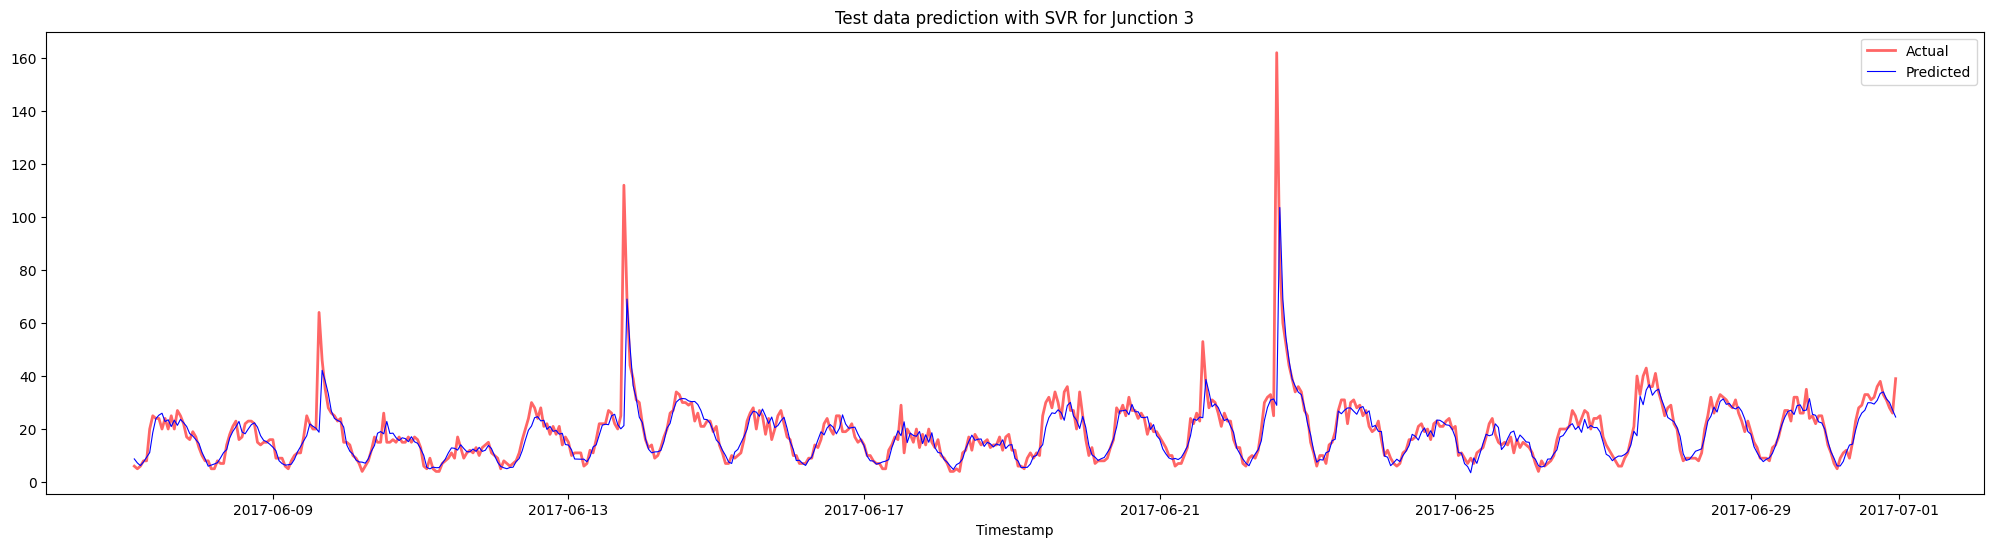

In [44]:
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test3, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred_svr_j3, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Test data prediction with SVR for Junction 3")
plt.show()

In [45]:
plt.figure(figsize=(25,6))
plt.plot(test_timestamps4, y_test4, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps4, y_test_pred_svr_j4, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Test data prediction with SVR for Junction 4")
plt.show()

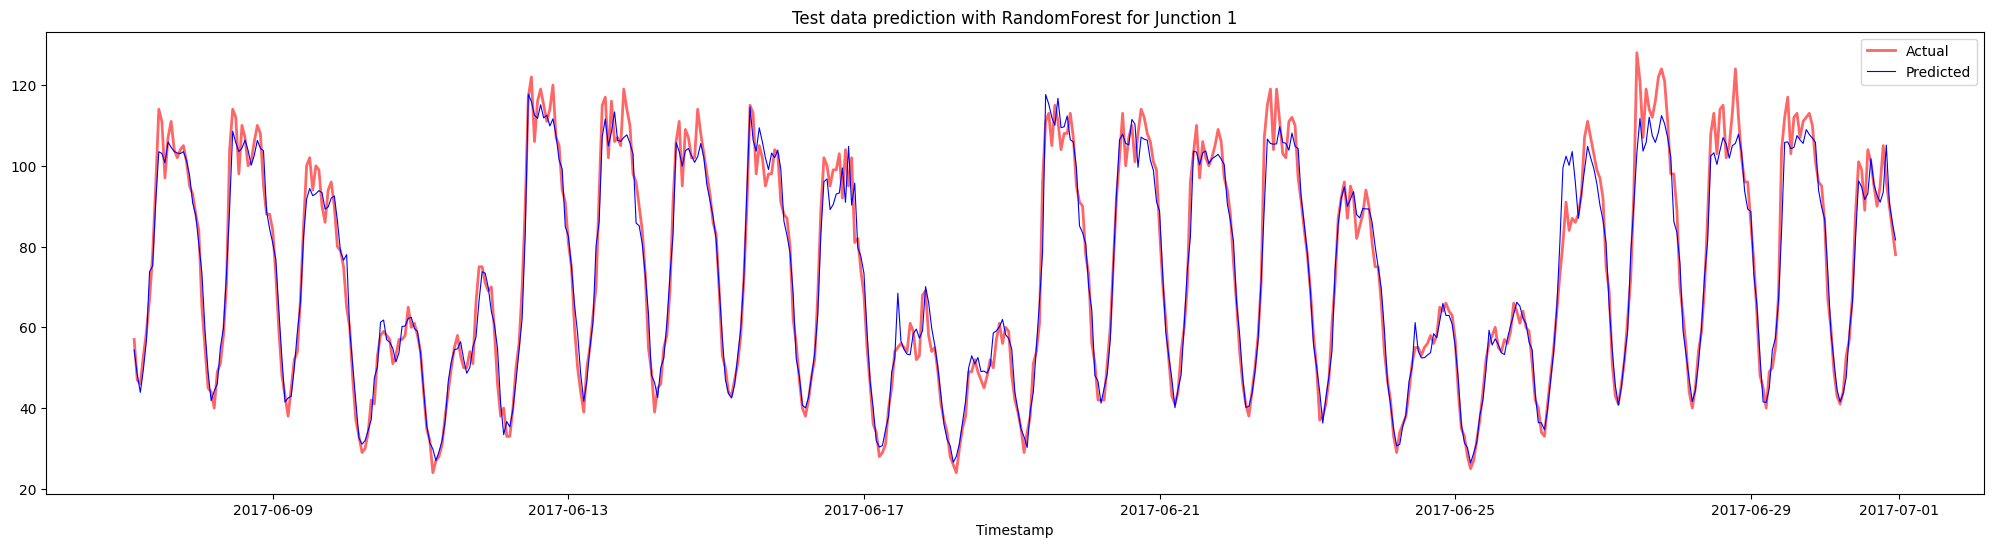

In [46]:
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test1, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred_rf_j1, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Test data prediction with RandomForest for Junction 1")
plt.show()

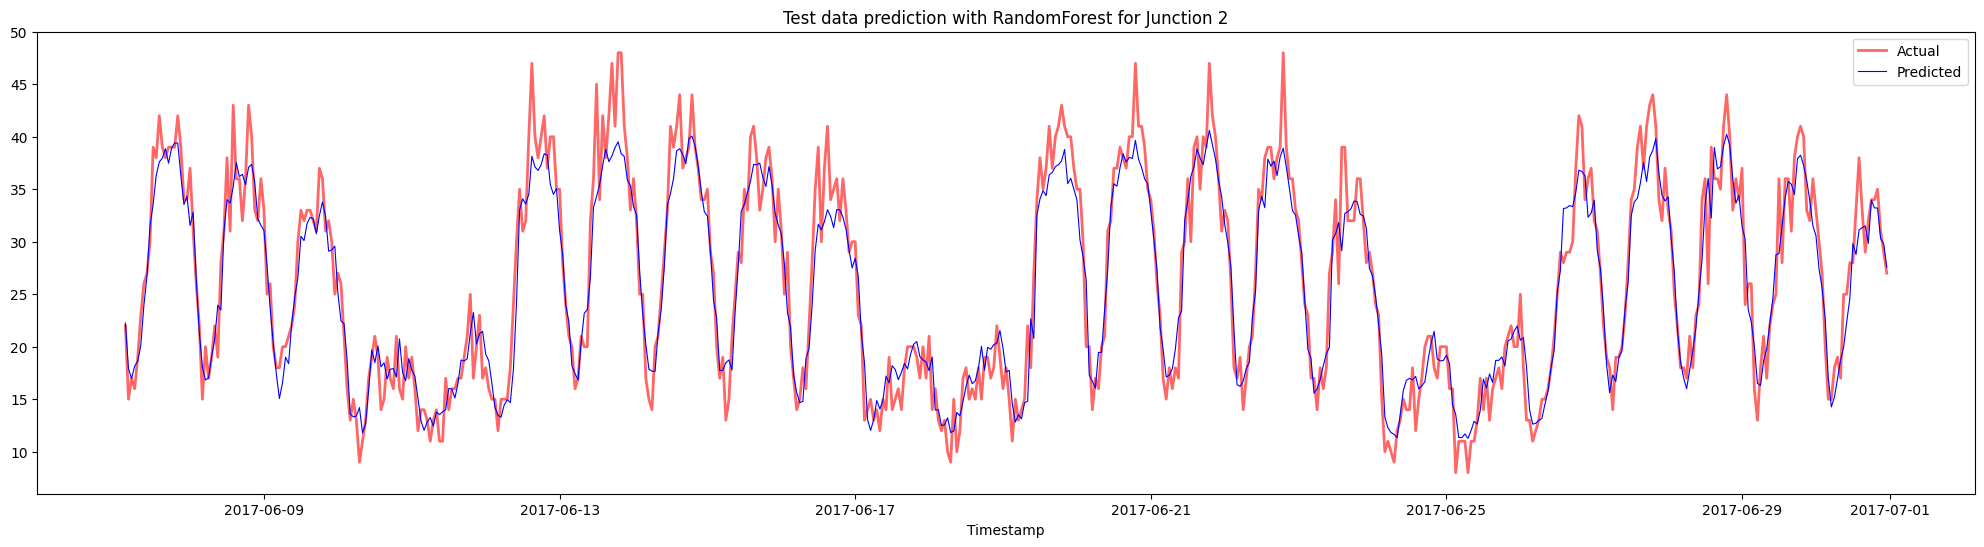

In [47]:
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test2, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred_rf_j2, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Test data prediction with RandomForest for Junction 2")
plt.show()

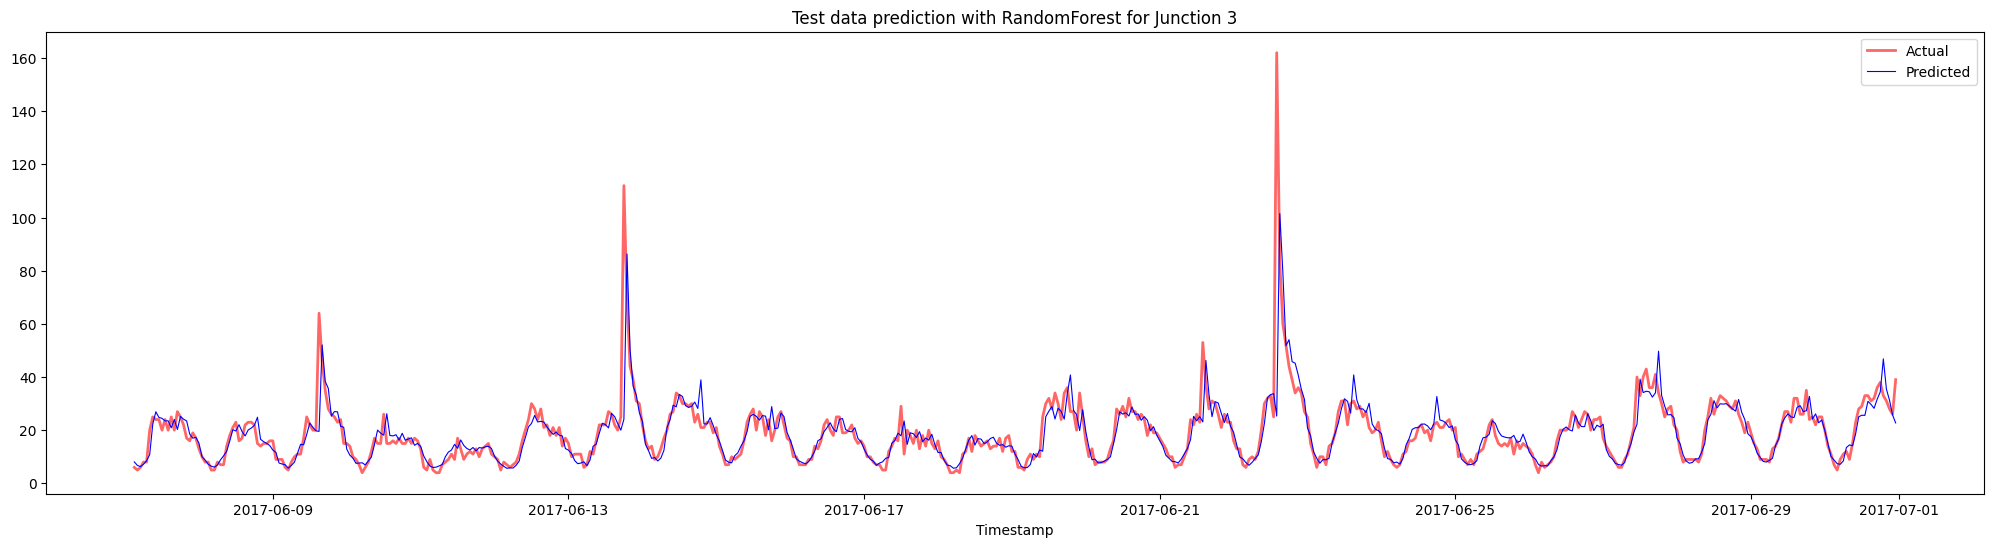

In [48]:
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test3, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred_rf_j3, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Test data prediction with RandomForest for Junction 3")
plt.show()

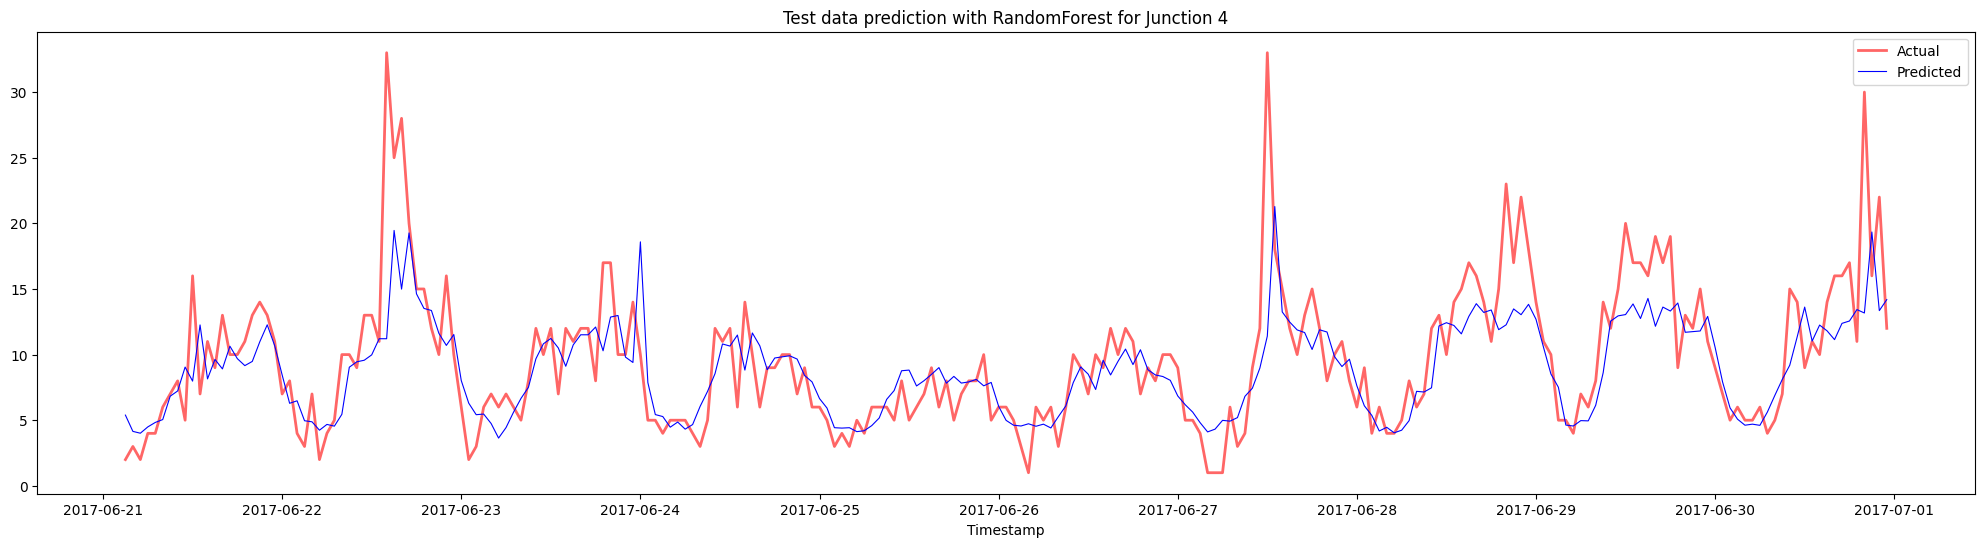

In [49]:
plt.figure(figsize=(25,6))
plt.plot(test_timestamps4, y_test4, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps4, y_test_pred_rf_j4, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Test data prediction with RandomForest for Junction 4")
plt.show()